### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
!readlink -f .

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


In [4]:
import torch
import mubind as mb
import scanpy as sc

In [5]:
!ls -ltrh /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022*

-rw-rw-r-- 1 ilibarra ilibarra  18M Jun 10 02:06 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_0.pth
-rw-rw-r-- 1 ilibarra ilibarra  21M Jun 10 02:06 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_1.pth
-rw-rw-r-- 1 ilibarra ilibarra 909M Jun 10 02:06 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_sample_train.h5ad
-rw-rw-r-- 1 ilibarra ilibarra  18M Jun 13 02:51 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_0_obs7468.pth
-rw-rw-r-- 1 ilibarra ilibarra  21M Jun 13 02:51 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_1_obs7468.pth
-rw-rw-r-- 1 ilibarra ilibarra 887M Jun 13 02:51 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_sample_train_obs7468.h5ad
-rw-rw-r-- 1 ilibarra ilibarra 833K Jul  5 00:27 /home/ilibarra/workspace/theislab/mubin

In [6]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [7]:
# query
obs_id = 1646 # publication case
# obs_id = 7359 # testing hadamard
# 7359
import os
# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'neuroorganoids_use_logdynamic_%i_obs%s.pth' % (use_logdynamic, obs_id)
    print(os.path.exists(p), p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

True neuroorganoids_use_logdynamic_0_obs1646.pth


True neuroorganoids_use_logdynamic_1_obs1646.pth


In [8]:
ad = sc.read_h5ad('neuroorganoids_sample_train_obs%s.h5ad' % obs_id)
# ad = sc.read_h5ad('atac_train.h5ad')
#rna_sample = sc.read_h5ad('rna_sample_train.h5ad')
rna_sample = ad

In [9]:
rna_sample.shape

(1646, 19883)

In [10]:
import pickle
train = pickle.load(open('neuroorganoids_train_dataloader_obs%s.pkl' % obs_id, 'rb'))

In [11]:
%load_ext line_profiler

In [12]:
# # load the pancreas multiome dataset
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')


In [13]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [14]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [15]:
import matplotlib.pyplot as plt

False
order None
0 out of 288...


break


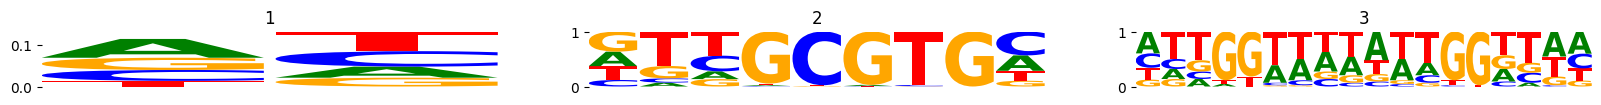

True
order None
0 out of 288...
break


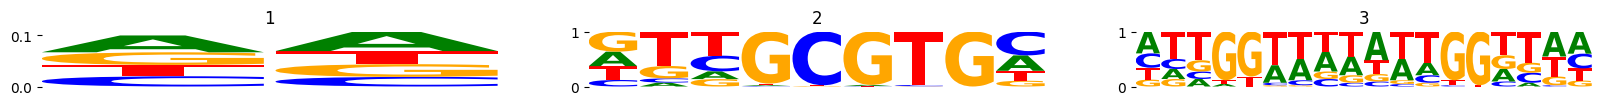

In [16]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4) #  log=True)
    plt.show()


True


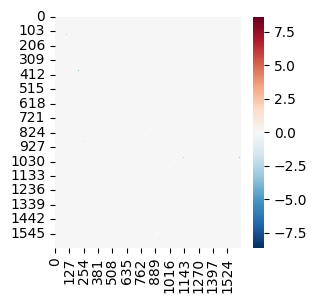

In [17]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

In [18]:
model = model_by_logdynamic[1]

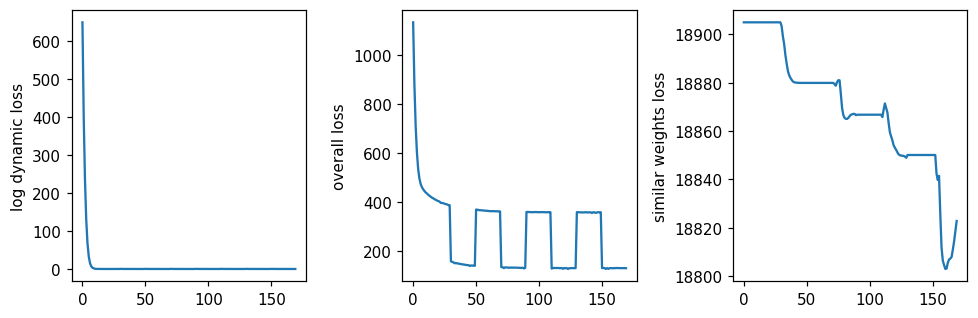

In [19]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.tight_layout()
plt.show()

In [20]:
import pandas as pd
import numpy as np

False
True


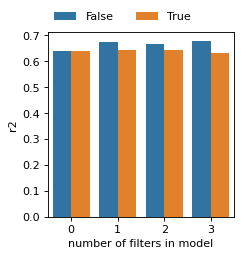

In [21]:
rcParams['figure.figsize'] = 3, 5
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 3, 3
    rcParams['figure.dpi'] = 80
    ax = sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic', )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False)

    plt.xlabel('number of filters in model')
    plt.show()

   index        r2  opt_log_dynamic
3      3  0.678699            False
3      3  0.630149             True


<Axes: xlabel='opt_log_dynamic', ylabel='r2'>

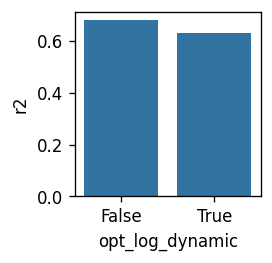

In [22]:
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = 2, 2
df = r2_all.sort_values('index', ascending=False).groupby('opt_log_dynamic').head(1)
print(df)
sns.barplot(df, y='r2', x='opt_log_dynamic')

In [23]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [24]:
ad.obs['dynamic_score'].describe()

count    1646.000000
mean        0.412133
std         0.073884
min         0.000000
25%         0.406668
50%         0.412133
75%         0.412805
max         1.000000
Name: dynamic_score, dtype: float64

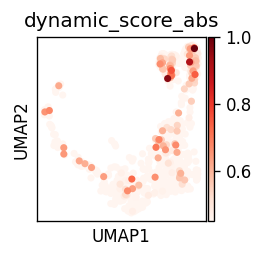

In [25]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

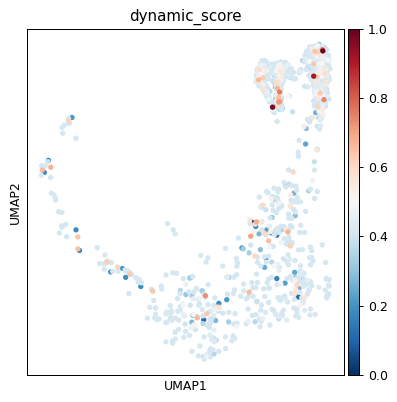

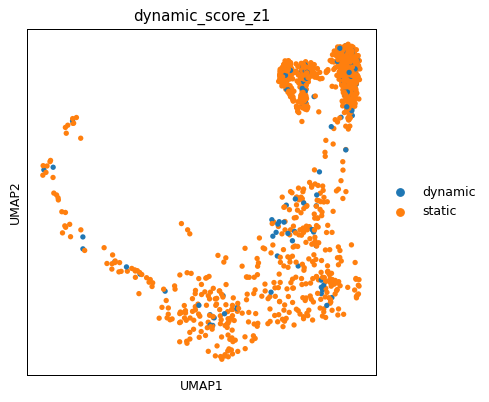

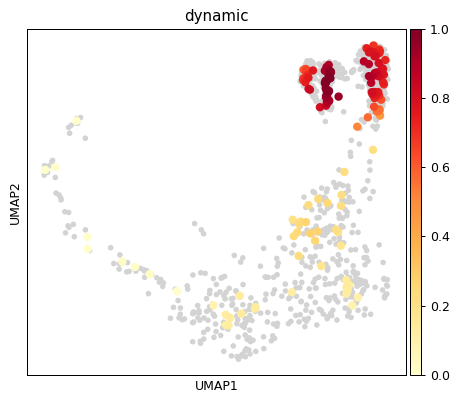

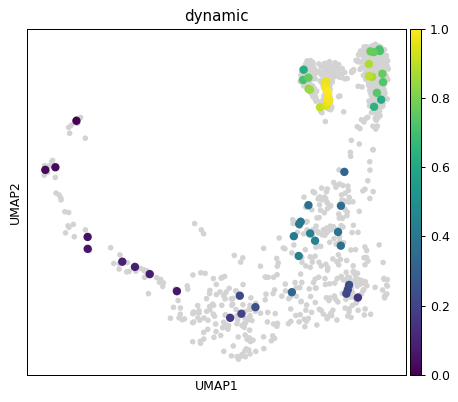

In [26]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

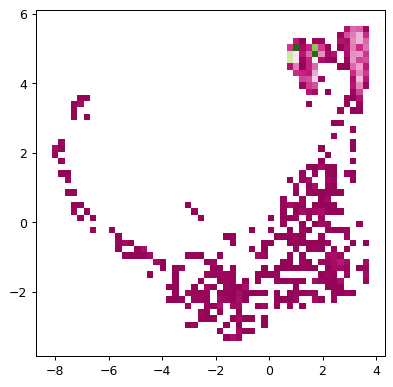

In [27]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

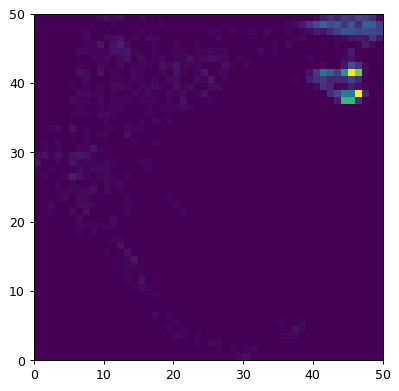

In [28]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [29]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [30]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


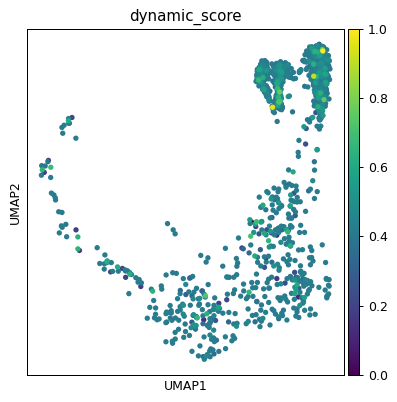

In [31]:
sc.pl.umap(ad, color='dynamic_score')

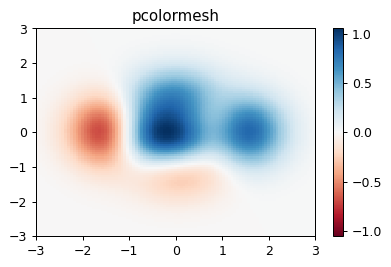

In [32]:
import matplotlib.pyplot as plt
import numpy as np
rcParams['figure.figsize'] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [33]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [34]:
cell_type_key = 'neuron_type'

In [35]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs[cell_type_key].cat.codes.values, size_x=1, size_y=1)

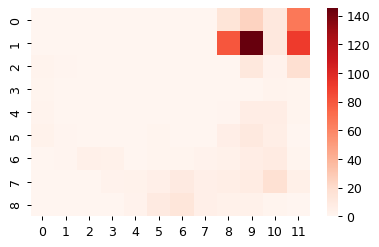

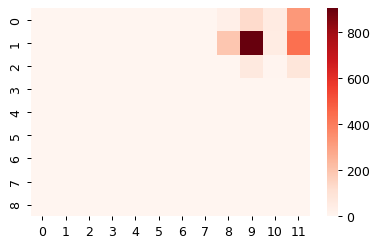

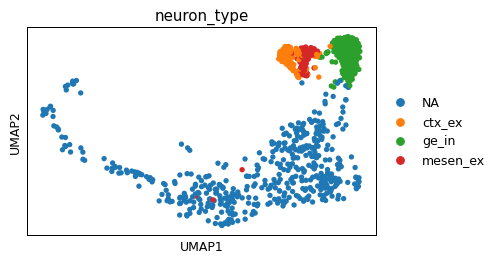

In [36]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color=cell_type_key)

In [37]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()


In [38]:
model = model_by_logdynamic[True]

In [39]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense() # (C, C)

In [40]:
# number of non_zero weights
len(G[G != 0])

20134

In [41]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [42]:
print('here...')

here...


In [43]:
ad

AnnData object with n_obs × n_vars = 1646 × 19883
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_cells_RNA', 'n_cells_ATAC', 'line', 'age', 'nCount_peaks', 'nFeature_peaks', 'S.Score', 'G2M.Score', 'Phase', 'nowakowski_prediction', 'RNA_snn_res.1', 'seurat_clusters', 'glyc_cluster', 'nCount_css', 'nFeature_css', 'RNA_snn_res.0.8', 'DF', 'MH', 'VF', 'X1', 'pred_class', 'ac_pole', 'antihem', 'cortical_hem', 'hindbrain_floor_plate', 'hindbrain_roof_plate', 'hypothalamic_floor_plate', 'isthmus', 'midbrain_basal_plate', 'midbrain_floor_plate', 'roof_plate', 'telencephalic_roof_plate', 'zona_limitans', 'pred_region', 'RNA_snn_res.2', 'patterning_region', 'n_counts', 'velocity_self_transition', 'neuron_type', 'terminal_states', 'terminal_states_probs', 'to_terminal_states_dp', 'clusters_gradients', 'to_ctx', 'to_nt', 'to_ge', 'velocity_pseudotime', 'to_nt_ranks', 'to_ge_ranks', 'to_ctx_ranks', 'is_root', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic

In [44]:
model = model.cuda()

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
# device

In [46]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [47]:
train.batch_size

256

In [48]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic].cuda()

    umap = ad.obsm["X_umap"].copy()
    umap = np.sort(umap, 0)

    x = umap[:, 0]
    y = umap[:, 1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    binding_per_mode = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum, "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs["scale_countsum"] = model.datatype == "selex"
        output = model(**inputs, use_conn=False, return_binding_scores=True)
        output = output.cpu().detach().numpy()
        # print("here...")
        # print(output.shape)
        # print(output.sum())
        pred.append(output)


        output = model(**inputs, use_conn=False, return_binding_per_mode=True)
        output = output.cpu().detach().numpy()
        print("here...")
        # print(output.shape)
        # print(output.sum())
        binding_per_mode.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T
    binding_per_mode = np.concatenate(binding_per_mode)

    # ad.layers['velocity'] = pred

    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()

    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']

    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True
here...
here...
here...
here...
here...
here...
here...


In [49]:
import scvelo as scv

In [50]:
ad.shape, binding_per_mode.shape, binding_scores.shape

((1646, 19883), (1646, 288), (1646, 1646))

In [51]:
ad
ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

ValueError: Value passed for key 'velocity' is of incorrect shape. Values of layers must match dimensions ('obs', 'var') of parent. Value had shape (1646, 1646) while it should have had (1646, 19883).

In [52]:
np.random.shuffle(binding_scores)
binding_scores

array([[3267187. , 3021037.5, 2847642.8, ..., 2437426.8, 2477134.5,
        2158003. ],
       [4095057. , 3790020.8, 3598780.8, ..., 2976316. , 3018336.2,
        2709070.2],
       [2835657. , 2641068.5, 2478820.2, ..., 2183107. , 2214041.2,
        1921339.4],
       ...,
       [3018046. , 2782166.2, 2647321. , ..., 2228134.2, 2257748.2,
        2041660.9],
       [3549892. , 3280913.5, 3104568.2, ..., 2619020.8, 2657527. ,
        2351277.8],
       [3907840.5, 3605588. , 3436645.2, ..., 2834339.5, 2871860. ,
        2608044. ]], dtype=float32)

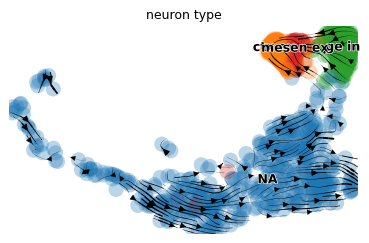

In [53]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color=cell_type_key)
except Exception:
    print("sample too small.")

In [54]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [55]:
# model_by_log

In [56]:
import seaborn as sns
act_on = model_by_logdynamic[True].get_log_activities().detach().cpu().squeeze(0)
act_off = model_by_logdynamic[False].get_log_activities().detach().cpu().squeeze(0)


<Axes: >

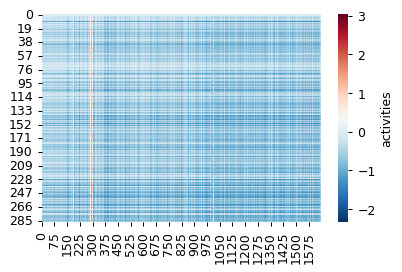

In [57]:
sns.heatmap(act_on, cmap='RdBu_r', cbar_kws={'label': 'activities'})

In [58]:
# highlight the top-n filters per cell, with the top variability
rcParams['figure.dpi'] = 100
n_show = 15
print(act.var(axis=1).sort()[1][-n_show:])
act_sel = act[act.var(axis=1).sort()[1][-n_show:],:]
vmax = act_sel.abs().max()
sns.clustermap(act_sel,
               vmin=-vmax / 2, vmax=vmax / 2,
               cmap='RdBu_r',
               
               cbar_kws={'label': 'activities'},
               figsize=[5, 3])


NameError: name 'act' is not defined

In [ ]:
rna_sample.layers['velocity'].shape, rna_sample.shape

((7359, 1948), (7359, 1948))

In [59]:
# scv.pl.velocity_graph(rna_sample)

In [60]:

# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [61]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [62]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

## Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [63]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 1646 × 19883
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_cells_RNA', 'n_cells_ATAC', 'line', 'age', 'nCount_peaks', 'nFeature_peaks', 'S.Score', 'G2M.Score', 'Phase', 'nowakowski_prediction', 'RNA_snn_res.1', 'seurat_clusters', 'glyc_cluster', 'nCount_css', 'nFeature_css', 'RNA_snn_res.0.8', 'DF', 'MH', 'VF', 'X1', 'pred_class', 'ac_pole', 'antihem', 'cortical_hem', 'hindbrain_floor_plate', 'hindbrain_roof_plate', 'hypothalamic_floor_plate', 'isthmus', 'midbrain_basal_plate', 'midbrain_floor_plate', 'roof_plate', 'telencephalic_roof_plate', 'zona_limitans', 'pred_region', 'RNA_snn_res.2', 'patterning_region', 'n_counts', 'velocity_self_transition', 'neuron_type', 'terminal_states', 'terminal_states_probs', 'to_terminal_states_dp', 'clusters_gradients', 'to_ctx', 'to_nt', 'to_ge', 'velocity_pseudotime', 'to_nt_ranks', 'to_ge_ranks', 'to_ctx_ranks', 'is_root', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynam

In [64]:
rna_sel = rna_sample # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(1646, 19883)

In [65]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [66]:
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'

anno = mb.datasets.archetypes_anno()

In [67]:
rna_sel.shape
anno.sort_values('Cluster_ID')

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
61,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
72,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
79,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
80,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
81,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
...,...,...,...,...,...,...,...,...
163,282,PAX/2,PAX,PAX5_HUMAN.H11MO.0.A,24,4,21,3
161,283,PAX-halfsite,PAX,Pax2_MA0067.1,8,1,7,1
0,284,AHR,bHLH,AHR_HUMAN.H11MO.0.B,9,2,8,3
105,285,KLF/SP/3,C2H2,KLF8_HUMAN.H11MO.0.C,9,0,9,2


In [68]:
print('here...')

here...


In [69]:
# log_act

False


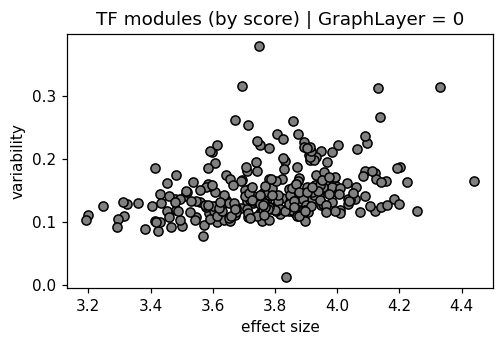

True


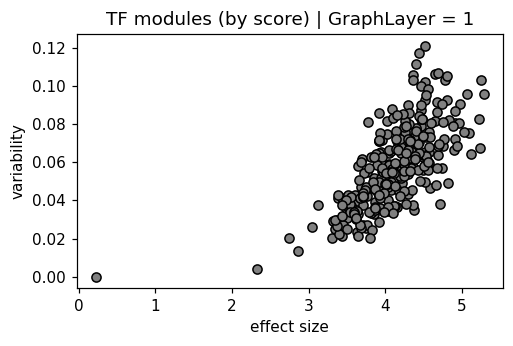

In [70]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 110})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var, color='gray', edgecolors='black')
    plt.xlabel('effect size')
    plt.ylabel('variability')
    plt.title('TF modules (by score) | GraphLayer = %i' % optimize_log_dynamic )
    plt.show()

In [71]:
# unique names for annotation
names = anno['Name'] # .sort_values('Name')
added = dict()
new_name = []
for name in names:
    if not name in added:
        new_name.append(name)
        added[name] = 0
    else:
        new_name.append(name + '_%i' % added[name])
        added[name] += 1
anno['Name_unique'] = new_name


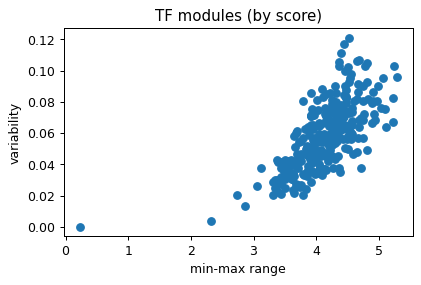

In [72]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        # print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])



In [73]:

# add archetypes name
meta = pd.DataFrame(pd.concat([delta, var], axis=1))
meta.columns = ['max_effect', 'variability']
meta['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
meta['archetypes_name'] = meta['name'].map(anno.set_index('Cluster_ID')['Name_unique'])
meta['archetypes_name'] = np.where(pd.isnull(meta['archetypes_name']), meta['name'], meta['archetypes_name'])

meta['archetypes_seed'] = meta['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])

meta['filter_position'] = range(0, meta.shape[0])

In [74]:
meta = meta.sort_values('max_effect', ascending=0)
meta

res = res.merge(meta, left_on='archetype_id', right_on='name')
res = res.sort_values('p_val', ascending=True)

In [75]:
name_by_filter_id = meta['archetypes_name'].to_dict()
# name_by_filter_id

## Observe general scores per case

In [76]:
res

,opt_log_dynamic,archetype_id,spearman,p_val,max_effect,variability,name,archetypes_name,archetypes_seed,filter_position
53,True,52,-0.182035,9.919688e-14,4.541689,0.060943,52,CCAAT/CEBP,CEBPA_HUMAN.H11MO.0.A,53
249,True,248,-0.181572,1.147380e-13,4.940603,0.068638,248,NR/20,ANDR_MOUSE.H11MO.0.A,249
41,True,40,-0.171409,2.544866e-12,4.749632,0.068424,40,NR/11,ERR2_MOUSE.H11MO.0.A,41
235,True,234,-0.161754,4.082971e-11,4.885867,0.079185,234,P53-like/3,Tp53.mouse_p53l_1,235
93,True,92,-0.153903,3.459312e-10,4.807168,0.092724,92,SOX/3,SOX10_HMG_4,93
...,...,...,...,...,...,...,...,...,...,...
19,True,18,-0.071368,3.767849e-03,3.641819,0.058125,18,HD/13,CDX1_HUMAN.H11MO.0.C,19
59,True,58,-0.070727,4.093270e-03,3.431483,0.041464,58,Ebox/CACGTG/1,ARNTL_bHLH_1,59
72,True,71,-0.069988,4.499830e-03,2.743688,0.020217,71,TBX/2,MGA_TBX_2,72
209,True,208,-0.069515,4.778801e-03,4.019049,0.081420,208,ZNF146,OZF_HUMAN.H11MO.0.C,209


<Axes: xlabel='max_effect', ylabel='archetypes_name'>

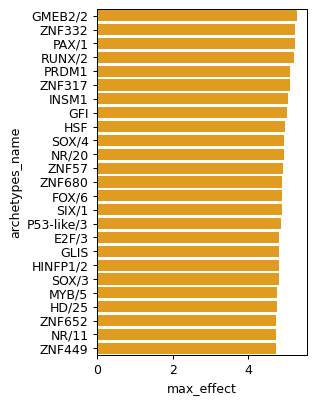

In [77]:
rcParams['figure.figsize'] =3, 5
sns.barplot(data=res.sort_values('max_effect', ascending=False).head(25), x='max_effect', y='archetypes_name', color='orange')

In [78]:
res

,opt_log_dynamic,archetype_id,spearman,p_val,max_effect,variability,name,archetypes_name,archetypes_seed,filter_position
53,True,52,-0.182035,9.919688e-14,4.541689,0.060943,52,CCAAT/CEBP,CEBPA_HUMAN.H11MO.0.A,53
249,True,248,-0.181572,1.147380e-13,4.940603,0.068638,248,NR/20,ANDR_MOUSE.H11MO.0.A,249
41,True,40,-0.171409,2.544866e-12,4.749632,0.068424,40,NR/11,ERR2_MOUSE.H11MO.0.A,41
235,True,234,-0.161754,4.082971e-11,4.885867,0.079185,234,P53-like/3,Tp53.mouse_p53l_1,235
93,True,92,-0.153903,3.459312e-10,4.807168,0.092724,92,SOX/3,SOX10_HMG_4,93
...,...,...,...,...,...,...,...,...,...,...
19,True,18,-0.071368,3.767849e-03,3.641819,0.058125,18,HD/13,CDX1_HUMAN.H11MO.0.C,19
59,True,58,-0.070727,4.093270e-03,3.431483,0.041464,58,Ebox/CACGTG/1,ARNTL_bHLH_1,59
72,True,71,-0.069988,4.499830e-03,2.743688,0.020217,71,TBX/2,MGA_TBX_2,72
209,True,208,-0.069515,4.778801e-03,4.019049,0.081420,208,ZNF146,OZF_HUMAN.H11MO.0.C,209


order None
0 out of 288...
10 out of 288...
break


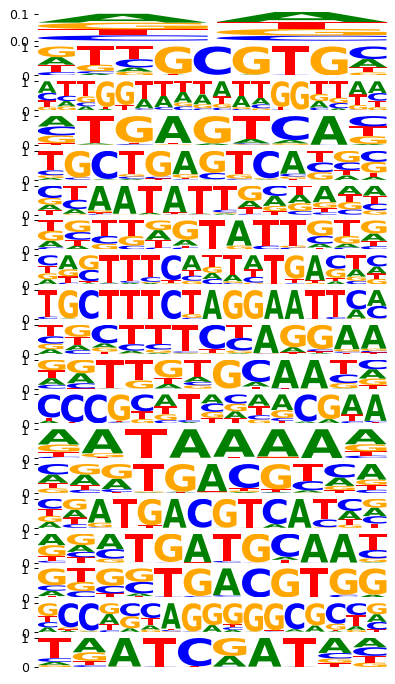

In [79]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

order Index([ 53, 249,  41, 235,  93,  94, 179, 180, 273, 234,  18,  57, 265, 282,
       106, 262, 263,  88, 252, 276],
      dtype='int64')
0 out of 288...


10 out of 288...


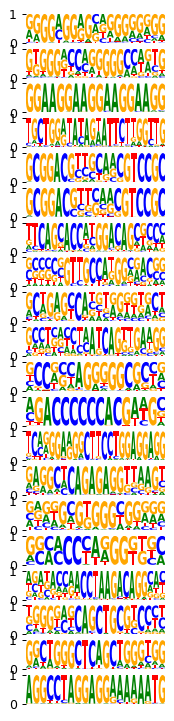

<Figure size 180x1800 with 0 Axes>

In [80]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [81]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 1.83054


In [82]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [83]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [84]:
vars_mapper = {}
def find_varname(ad, k, shuffle=False, ):
    if not shuffle:
        if k in vars_mapper:
            return vars_mapper[k]
        else:
            result = ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
            vars_mapper[k] = result
            return result
    else:
        ad_sel = ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
        return pd.Series(ad.var_names).sample(ad_sel.shape[0]).values

In [85]:
from scipy.stats import spearmanr, pearsonr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [86]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')


False


True


In [87]:

def get_act_gene_corr(model_by_logdynamic, shuffle=False, random_state=0):
    print('association between motif activities and related TF targets (shuffle = %i)' % shuffle)
    res = []
    # print(len(all_targets))

    rna_sel_df = rna_sel.to_df()

    for optimize_log_dynamic in model_by_logdynamic:
        print('use GraphLayer = %i' % optimize_log_dynamic)
        model = model_by_logdynamic[optimize_log_dynamic]

        log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
        log_act = pd.DataFrame(log_act.detach().cpu().numpy())
        log_act.index = ad.obs_names

        ad.obsm['log_activities'] = log_act
        ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

        if shuffle:
            random_cols = ad.obsm['log_activities'].iloc[:,2:].columns.values
            np.random.shuffle(random_cols)
            # random_cols
        
        for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
            next_log_act = ad.obsm['log_activities'][k].values

            # if shuffle:
            #     next_log_act = ad.obsm['log_activities'][random_cols[ki]].values
            
            # print(ki)
            # if ki % 30 == 0:
            #     print(ki)
            names = set()
            clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
            for g in clu_sel:
                names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
            for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
                names.add(g.split('_')[0].split('.')[0])
            # print(k, names)
            next_targets = set()
            for name in names:
                target = find_varname(rna_sel, name, shuffle=shuffle)
                # print(name, target)
                for t in target:
                    next_targets.add(t)

            # for t in all_targets:
            for t in set(all_targets).intersection(next_targets):
                gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
                assert gex.shape[1] == 1
                gex = gex.flatten()
                # print(next_log_act.shape, gex.shape)
                # print(t, pearsonr(next_log_act, gex))
                res.append([ki, optimize_log_dynamic, k, t, t in next_targets] +
                        list(spearmanr(next_log_act, gex)))
                
    res = pd.DataFrame(res, columns=['filter_id', 'opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

    # p-values
    res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
    res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])
    
    # p-val adjust
    from statsmodels.stats.multitest import fdrcorrection
    res['p_adj'] = fdrcorrection(res['p_val'])[1]
    return res


In [88]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [89]:
%lprun -f get_act_gene_corr get_act_gene_corr(model_by_logdynamic, shuffle=0)

association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0


use GraphLayer = 1


Timer unit: 1e-09 s

Total time: 15.9703 s
File: /tmp/ipykernel_22410/1219755437.py
Function: get_act_gene_corr at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_act_gene_corr(model_by_logdynamic, shuffle=False, random_state=0):
     2         1     472112.0 472112.0      0.0      print('association between motif activities and related TF targets (shuffle = %i)' % shuffle)
     3         1       1055.0   1055.0      0.0      res = []
     4                                               # print(len(all_targets))
     5                                           
     6         1  161795045.0    2e+08      1.0      rna_sel_df = rna_sel.to_df()
     7                                           
     8         3       4488.0   1496.0      0.0      for optimize_log_dynamic in model_by_logdynamic:
     9         2     286533.0 143266.5      0.0          print('use GraphLayer = %i' % optimize_log_dynamic)
    10   

In [90]:
res = get_act_gene_corr(model_by_logdynamic)
shuffled = [get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i) for i in range(10)]

association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLa

In [91]:
table = []
for use_graph in [False, True]:
    for thr in range(1, 10):
        sel = res[res['opt_log_dynamic'] == use_graph]
        next_thr = 10 ** (-thr)
        n_pos = sel[sel['p_adj'] < next_thr].shape[0]
        n_neg = [s[(s['p_adj'] < next_thr) & (s['opt_log_dynamic'] == use_graph)].shape[0] for s in shuffled]
        # print(next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg))
        table.append([next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg), use_graph])
table = pd.DataFrame(table, columns=['p_adj_thr', 'n_pos', 'mu', 'sigma', 'zscore', 'graph_layer'])
table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore')

p_adj_thr,1.000000e-09,1.000000e-08,1.000000e-07,1.000000e-06,1.000000e-05,1.000000e-04,1.000000e-03,1.000000e-02,1.000000e-01
graph_layer,,,,,,,,,
False,68.081498,64.989281,68.568315,76.115646,73.443502,75.040185,88.250000,122.22418,136.458558
True,53.086257,45.199504,51.467125,48.799397,60.337424,65.764054,68.911298,74.56762,79.838694


Text(0.5, 1.0, 'associations between activity layer and TF (GEX)')

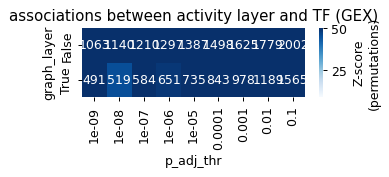

In [92]:
rcParams['figure.figsize'] = 4, 1
hm = table.pivot(index='graph_layer', columns='p_adj_thr', values='n_pos').fillna(0)
z = table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore').fillna(0)
sns.heatmap(z, annot=hm, fmt='', cmap='Blues', cbar_kws={'label': 'Z-score\n(permutations)'},
            vmin=9,
            vmax=50)
plt.title('associations between activity layer and TF (GEX)')

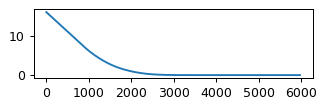

In [93]:
cumulative = np.cumsum(res.sort_values('p_adj')['p_adj']) / 100
plt.plot(range(len(cumulative)), cumulative[::-1])

In [94]:
shuffled[0].sort_values('p_val')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
51,64,False,79,TUBA1B,True,0.622771,1.994204e-177,FOX/4,1.501636e-174
195,148,False,70,TXNL1,True,0.579395,3.272293e-148,TBX/1,1.232018e-145
276,158,False,111,THRAP3,True,0.576271,2.830695e-146,EGR,7.105045e-144
635,99,True,70,TERF2IP,True,-0.570315,1.224032e-142,TBX/1,2.304240e-140
213,148,False,70,TXNL4A,True,0.562546,5.248408e-138,TBX/1,7.904103e-136
...,...,...,...,...,...,...,...,...,...
321,229,False,170,TBPL2,True,NaN,1.000000e+00,BCL6/2,1.000000e+00
339,244,False,253,TAS2R41,True,NaN,1.000000e+00,MYB/1,1.000000e+00
347,261,False,257,RUNX3,True,NaN,1.000000e+00,P53-like/1,1.000000e+00
281,168,False,85,MGAT4D,True,NaN,1.000000e+00,POU/1,1.000000e+00


In [95]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
1497,69,False,70,TPT1,True,0.725834,1.965084e-269,TBX/1,1.173548e-265
2805,247,False,248,ARPC2,True,0.669455,1.704523e-214,NR/20,5.089707e-211
4370,69,True,70,TAGLN3,True,-0.645481,1.201963e-194,TBX/1,2.392707e-191
2894,247,False,248,ARPC5,True,0.608671,1.970499e-167,NR/20,2.941955e-164
3706,69,True,70,TERF2IP,True,-0.606935,3.093696e-166,TBX/1,3.695111e-163
...,...,...,...,...,...,...,...,...,...
3585,69,True,70,TGIF2LX,True,NaN,1.000000e+00,TBX/1,1.000000e+00
3575,69,True,70,TRIM49,True,NaN,1.000000e+00,TBX/1,1.000000e+00
3565,69,True,70,TUBB8,True,NaN,1.000000e+00,TBX/1,1.000000e+00
3638,69,True,70,TAAR2,True,NaN,1.000000e+00,TBX/1,1.000000e+00


In [96]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
# res[res['p_adj'] < 0.1]

In [97]:
genes_by_module_name = res.groupby(['module_name'])['gene_name'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
# genes_by_module_name

In [98]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
1497,69,False,70,TPT1,True,0.725834,1.965084e-269,TBX/1,1.173548e-265
2805,247,False,248,ARPC2,True,0.669455,1.704523e-214,NR/20,5.089707e-211
4370,69,True,70,TAGLN3,True,-0.645481,1.201963e-194,TBX/1,2.392707e-191
2894,247,False,248,ARPC5,True,0.608671,1.970499e-167,NR/20,2.941955e-164
3706,69,True,70,TERF2IP,True,-0.606935,3.093696e-166,TBX/1,3.695111e-163
...,...,...,...,...,...,...,...,...,...
3585,69,True,70,TGIF2LX,True,NaN,1.000000e+00,TBX/1,1.000000e+00
3575,69,True,70,TRIM49,True,NaN,1.000000e+00,TBX/1,1.000000e+00
3565,69,True,70,TUBB8,True,NaN,1.000000e+00,TBX/1,1.000000e+00
3638,69,True,70,TAAR2,True,NaN,1.000000e+00,TBX/1,1.000000e+00


In [99]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot(index='k', columns='opt_log_dynamic', values='spearman')
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [100]:
df2

opt_log_dynamic,False,True
k,,
AHRR_284,0.075810,0.021709
AHR_284,0.117408,-0.017789
AIRE_139,0.047207,0.034534
ALX1_2,0.042330,0.037485
ALX1_8,0.031865,0.040188
...,...,...
ZNF880_231,0.090697,-0.042934
ZNF883_231,0.145782,-0.099980
ZNF891_231,0.104880,-0.108146


In [101]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)


In [102]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

In [103]:
# res['arch_name'] = name_by_filter_id

In [104]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
1497,69,False,70,TPT1,True,0.725834,1.965084e-269,TBX/1,1.173548e-265,TPT1_70
2805,247,False,248,ARPC2,True,0.669455,1.704523e-214,NR/20,5.089707e-211,ARPC2_248
4370,69,True,70,TAGLN3,True,-0.645481,1.201963e-194,TBX/1,2.392707e-191,TAGLN3_70
2894,247,False,248,ARPC5,True,0.608671,1.970499e-167,NR/20,2.941955e-164,ARPC5_248
3706,69,True,70,TERF2IP,True,-0.606935,3.093696e-166,TBX/1,3.695111e-163,TERF2IP_70
...,...,...,...,...,...,...,...,...,...,...
3585,69,True,70,TGIF2LX,True,NaN,1.000000e+00,TBX/1,1.000000e+00,TGIF2LX_70
3575,69,True,70,TRIM49,True,NaN,1.000000e+00,TBX/1,1.000000e+00,TRIM49_70
3565,69,True,70,TUBB8,True,NaN,1.000000e+00,TBX/1,1.000000e+00,TUBB8_70
3638,69,True,70,TAAR2,True,NaN,1.000000e+00,TBX/1,1.000000e+00,TAAR2_70


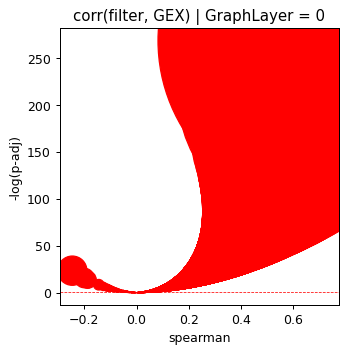

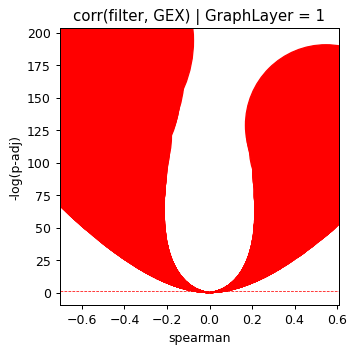

In [105]:
rcParams['figure.figsize'] = 4, 4
rcParams['figure.dpi'] = 90

for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 2), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('corr(filter, GEX) | GraphLayer = %i' % optimize_log_dynamic)
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

<Axes: xlabel='spearman', ylabel='Count'>

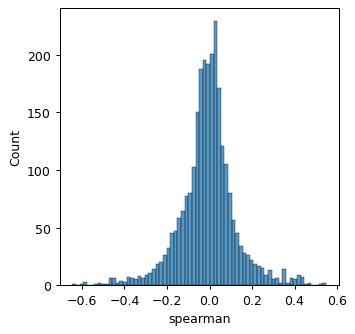

In [106]:
sns.histplot(grp['spearman'])

In [107]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

Text(0, 0.5, '# associations')

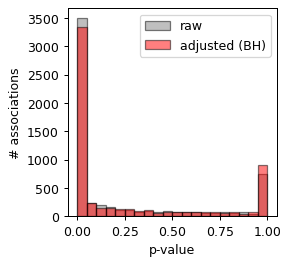

In [108]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 90
plt.hist(res['p_val'], color='gray', bins=20, label='raw', alpha=.5, edgecolor = 'black')
plt.hist(res['p_adj'], color='red', bins=20, label='adjusted (BH)', alpha=.5, edgecolor = 'black')
plt.xlabel('p-value')
plt.legend()
plt.ylabel('# associations')

In [109]:
res[res['p_adj'] < 0.05]

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
7,1,False,2,NKX6-2,True,0.064550,8.803140e-03,HD/2,1.712454e-02,NKX6-2_2
14,1,False,2,VENTX,True,0.144774,3.628840e-09,HD/2,1.289966e-08,VENTX_2
16,1,False,2,ARID3B,True,0.222115,7.604274e-20,HD/2,5.137186e-19,ARID3B_2
18,1,False,2,VSX1,True,0.066155,7.255398e-03,HD/2,1.426712e-02,VSX1_2
19,1,False,2,LHX8,True,-0.059994,1.491898e-02,HD/2,2.807063e-02,LHX8_2
...,...,...,...,...,...,...,...,...,...,...
5959,279,True,280,SIX3,True,0.377756,5.627779e-57,SIX/2,1.706045e-55,SIX3_280
5960,279,True,280,SIX3-AS1,True,0.113735,3.730642e-06,SIX/2,1.046964e-05,SIX3-AS1_280
5963,280,True,281,PAX6,True,0.159148,8.396880e-11,PAX/1,3.329759e-10,PAX6_281
5964,280,True,281,PAX2,True,0.086951,4.129310e-04,PAX/1,9.499322e-04,PAX2_281


In [110]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

In [111]:
log_act = ad.obsm['log_activities'].copy()

In [112]:
cols_act = ['intercept', 'dinuc_bias'] + [name_by_filter_id[k] for k in log_act.columns[2:]]
log_act.columns = cols_act

In [113]:
import anndata
ad_act = anndata.AnnData(log_act)
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

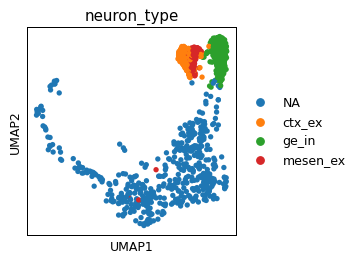

In [114]:
sc.pl.umap(ad_act, color=cell_type_key)


Rank genes groups using the annotation

In [115]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)
rkg_df = []
for ct in ad_act.obs[cell_type_key].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2[cell_type_key] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

NA
mesen_ex
ge_in
ctx_ex


,names,scores,logfoldchanges,pvals,pvals_adj,neuron_type,module_name
0,ARI5A,24.267336,-0.721071,9.485143e-91,2.731721e-88,NA,ARI5A
1,IRF/1,23.482555,-0.818837,3.745614e-86,5.393685e-84,NA,IRF/1
2,ZNF282,23.100542,-1.016267,9.710784e-85,9.322352e-83,NA,ZNF282
3,NR/17,22.994703,-0.666870,1.010761e-83,7.277481e-82,NA,NR/17
4,GMEB2/3,22.840996,-1.247673,1.764658e-83,1.016443e-81,NA,GMEB2/3


Get top modules

In [116]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

In [117]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)

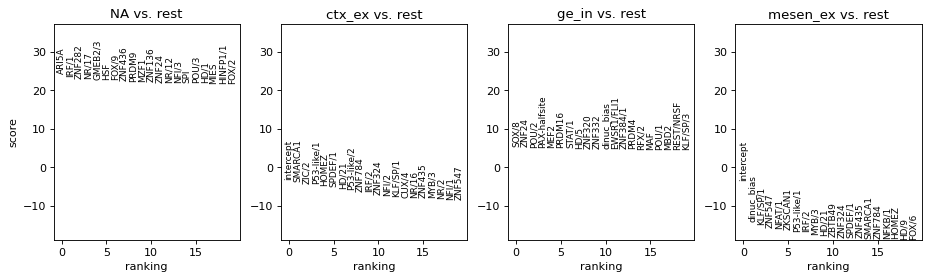

In [118]:
rcParams['figure.figsize'] = 3.5, 3.5
rcParams['figure.dpi'] = 80
sc.pl.rank_genes_groups(ad_act)


In [119]:
# set(res[(res['p_adj'] < 1e-5)]['k'])

In [120]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
146,20,False,21,PBX1,True,0.374006,8.446240e-56,HD/16,2.484776e-54,PBX1_21
3025,1,True,2,LHX9,True,-0.369263,2.469396e-54,HD/2,6.923583e-53,LHX9_2
3094,7,True,8,UNCX,True,-0.367000,1.210647e-53,HD/8,3.242144e-52,UNCX_8
3010,1,True,2,UNCX,True,-0.353259,1.443949e-49,HD/2,3.316639e-48,UNCX_2
3169,24,True,25,OTX2,True,0.351256,5.458789e-49,HD/19,1.211892e-47,OTX2_25
...,...,...,...,...,...,...,...,...,...,...
3040,1,True,2,ESX1,True,NaN,1.000000e+00,HD/2,1.000000e+00,ESX1_2
3041,1,True,2,HOXA10-AS,True,NaN,1.000000e+00,HD/2,1.000000e+00,HOXA10-AS_2
3044,1,True,2,HOXA11-AS,True,NaN,1.000000e+00,HD/2,1.000000e+00,HOXA11-AS_2
60,1,False,2,HOXD3,True,NaN,1.000000e+00,HD/2,1.000000e+00,HOXD3_2


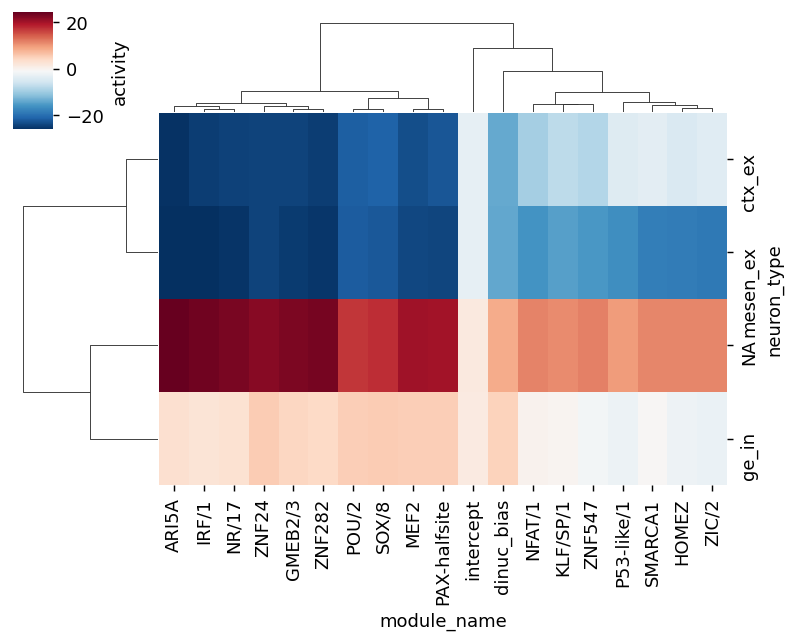

In [121]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby(cell_type_key).head(5)['module_name'])
best = rkg_df[rkg_df['module_name'].isin(mod_names_best)]
rcParams['figure.dpi'] = 130
sns.clustermap(best.pivot(index=cell_type_key, columns='module_name', values='scores'),
               cbar_kws={'label': 'activity'}, cmap='RdBu_r',
               # vmin=-5, vmax=5,
               figsize=[6.2, 5],
               # dpi=100,
               xticklabels=True)


In [122]:
rna_tfs = rna_sel.to_df()[list(set(res['gene_name']))]
rna_tfs[cell_type_key] = rna_sel.obs[cell_type_key]
mean_tfs = rna_tfs.groupby(cell_type_key).mean()

act_tfs_df = ad_act.to_df()
act_tfs_df[cell_type_key] = ad_act.obs[cell_type_key]
mean_act_tf = act_tfs_df.groupby(cell_type_key).mean()

In [123]:
corr_celltype = []
for i, c1 in enumerate(mean_act_tf):
    if i % 50 == 0:
        print(i, mean_act_tf.shape[1])
    for j, c2 in enumerate(mean_tfs):
        if not c1 in genes_by_module_name or not c2 in genes_by_module_name[c1]:
            continue
        a = mean_act_tf[c1]
        b = mean_tfs[c2]
        corr_celltype.append([c1, c2, mean_act_tf.index[np.argmax(mean_act_tf[c1])]] + list(pearsonr(a, b)))

corr = pd.DataFrame(corr_celltype,
                    columns=['module_name', 'gene_name', 'cell_type', 'pearsonr', 'p_val'])
corr = corr.sort_values('pearsonr', ascending=False)


0 288
50 288
100 288
150 288
200 288
250 288


In [124]:
# sc.pl.dotplot(rna_sel, groupby='celltype', var_names=list(set(res['gene_name'])))

In [125]:
corr[corr['pearsonr'] > 0].sort_values('p_val')

,module_name,gene_name,cell_type,pearsonr,p_val
2550,TBX/4,TBX15,NA,0.995946,0.004054
193,TBX/1,TNFRSF11B,NA,0.995077,0.004923
277,TBX/1,TPH2,NA,0.995077,0.004923
24,GC-tract,TAF1L,NA,0.994903,0.005097
1287,TBX/1,TNK1,NA,0.994696,0.005304
...,...,...,...,...,...
2364,NR/20,ARL9,NA,0.008220,0.991780
2644,KLF/SP/1,SP4,NA,0.003012,0.996988
551,TBX/1,TTN,NA,0.001849,0.998151
458,TBX/1,TTC9C,NA,0.001028,0.998972


repressors


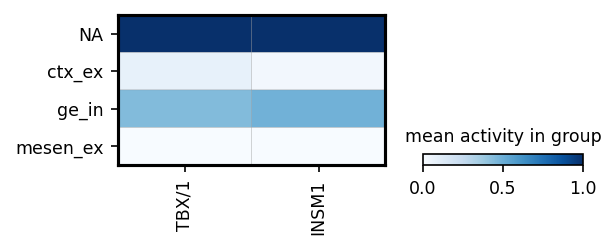

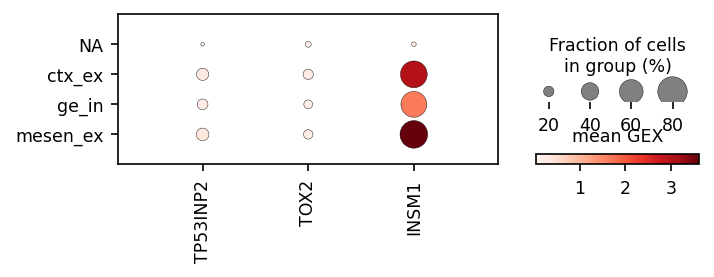

In [126]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 150

# repressors
print('repressors')

module_names = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.3],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.3])



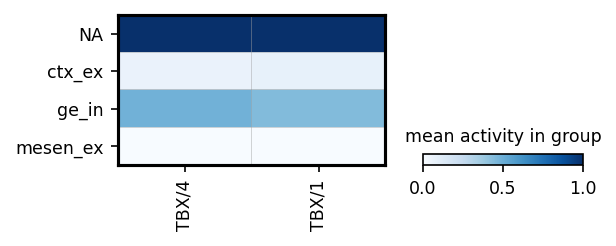

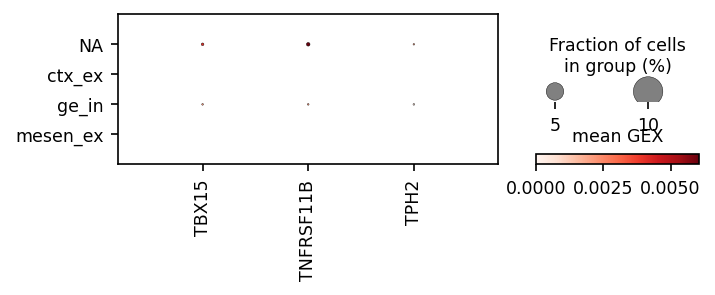

In [127]:
# activators
rcParams['pdf.fonttype'] = 42

module_names = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.3],
            show=False,
            standard_scale='var',
            colorbar_title='mean activity in group')

plt.savefig('../../../output/filter_activities_neurogenesis.pdf')
plt.show()


sc.pl.dotplot(rna_sel,
              show=False,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.3])

plt.savefig('../../../output/gene_expression_neurogenesis.pdf')
plt.show()


order 2550    72
193     69
Name: module_name, dtype: int64
0 out of 288...


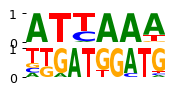

order 2550    72
193     69
Name: module_name, dtype: int64
0 out of 288...


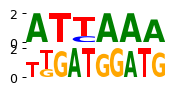

<Figure size 180x1800 with 0 Axes>

In [129]:
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    # stop_at=11,
    show=False,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    # log_odds=True,
    order=module_names.map(res.set_index('module_name')['filter_id'].to_dict()),
)  # n_cols=len(reduced_groups))
# plt.tight_layout()

plt.show()
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    # stop_at=11,
    show=False,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    log_odds=True,
    order=module_names.map(res.set_index('module_name')['filter_id'].to_dict()),
)  # n_cols=len(reduced_groups))
# plt.tight_layout()
plt.show()
# assert False

plt.savefig('../../../output/motif_neurogenesis.pdf')
plt.show()


In [130]:
!readlink -f ../../../output/motif_neurogenesis.pdf

/home/ilibarra/workspace/theislab/mubind/output/motif_neurogenesis.pdf


## Filter activities versus graph activities

In [131]:
A = model.get_log_activities()
sum_A = A.abs().sum(axis=1).cpu().detach().numpy()
A = A.squeeze(0)
print(A.shape)

torch.Size([288, 1646])


In [132]:
# this function assesses the contributions of A on the graph
indices, contributions, max_eig = mb.tl.compute_contributions(A, C * D)

contributions_normalized = torch.abs(contributions) / max_eig
contributions_df = pd.DataFrame(contributions_normalized.detach(), columns=['index'])
print("Summary statistics of the normalized contributions: \n")
contributions_df.describe()

Summary statistics of the normalized contributions: 



,index
count,288.000000
mean,0.091518
std,0.045203
min,0.071578
25%,0.081981
50%,0.086914
75%,0.093636
max,0.837018


In [133]:
contributions.shape

torch.Size([288])

Percentage of non-zero entries of the filter matrix A: 100.0 %
(288,) (288,)


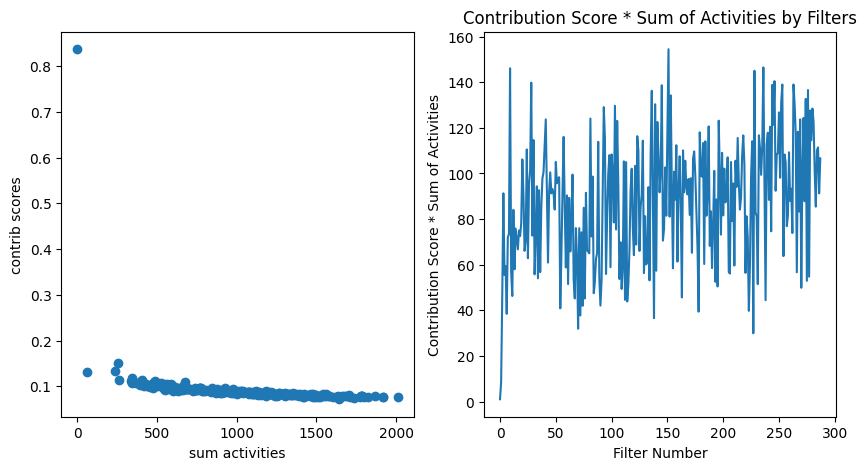

In [134]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 100
plt.figure(figsize=(10, 5))

print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")
mb.pl.filter_contrib_simple(contributions_normalized, A.cpu())

In [135]:
# normalize the data, and look at summary stats
sum_A_norm = sum_A / np.max(sum_A)
sum_A_df = pd.DataFrame(sum_A.T, columns=['sum_A'])
sum_A_df.describe()

,sum_A
count,288.000000
mean,1021.925110
std,393.565338
min,1.228686
25%,689.174484
50%,1026.888550
75%,1304.521057
max,2008.614136


In [136]:
contrib_arr = contributions_normalized.unsqueeze(dim=0).detach().numpy()
sum_A = A.cpu().abs().sum(axis=1).detach().numpy()
contrib = contrib_arr[0]

contrib_times_activities = contrib * sum_A
contrib_times_activities_norm = contrib_times_activities / np.max(contrib_times_activities)
contrib_times_activities_df = pd.DataFrame(contrib_times_activities, columns=['contribution_times_activities'])
contrib_times_activities_df.describe()

,contribution_times_activities
count,288.000000
mean,87.494415
std,27.223310
min,1.028432
25%,65.784737
50%,90.655857
75%,107.687620
max,154.482910


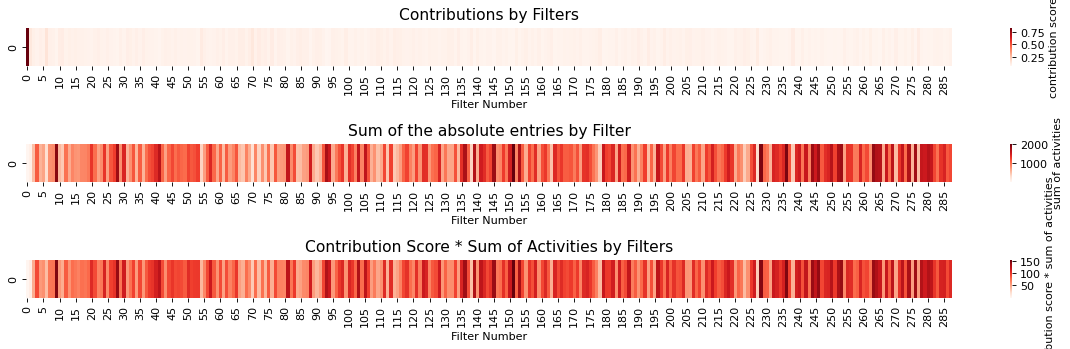

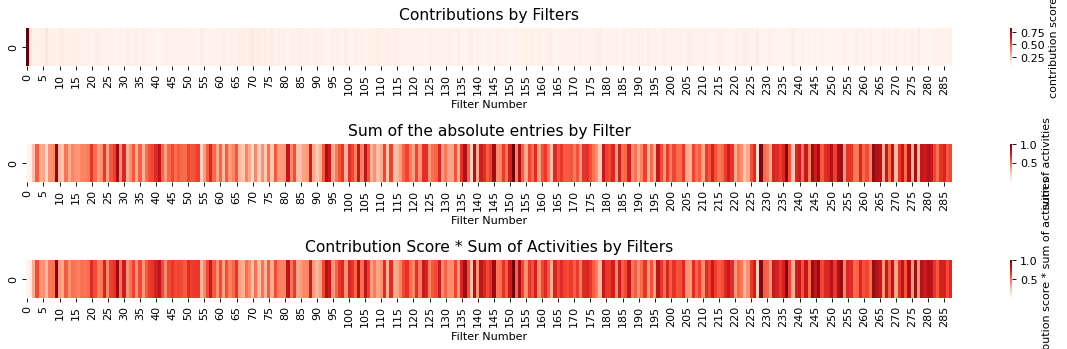

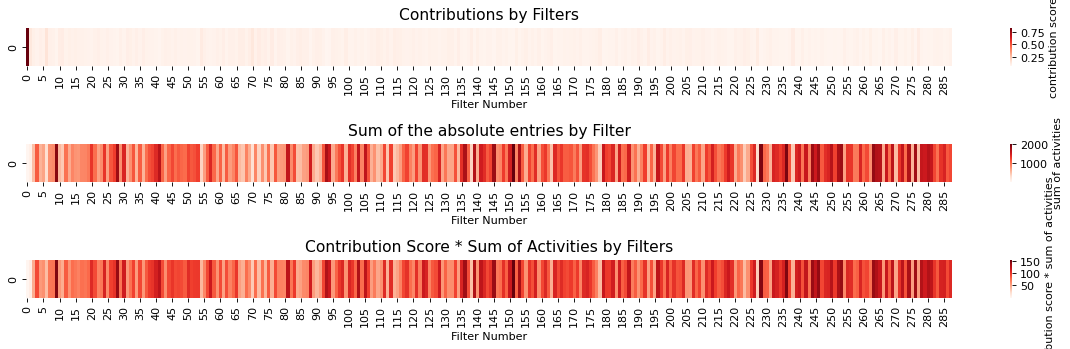

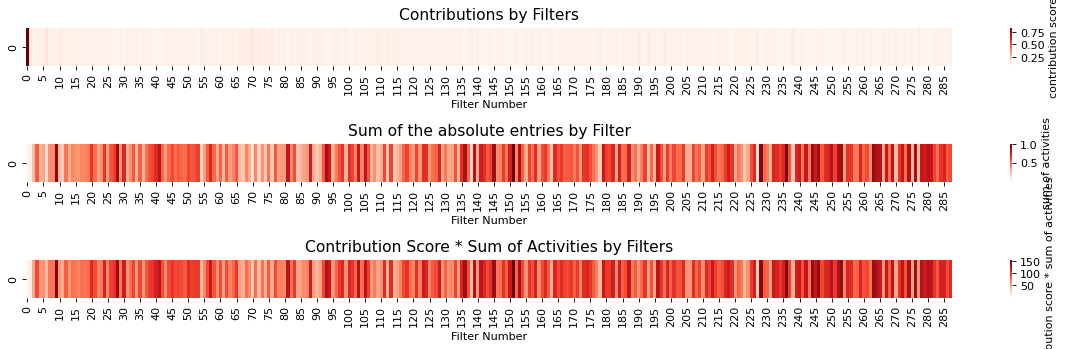

In [137]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 80

# unsqueeze the data to make it compatible with the heatmap function
sum_A_norm = sum_A_norm.reshape(1,-1)
contrib_times_activities = contrib_times_activities.reshape(1,-1)


# only plotting filters, that are within the top 25% of the maximum contribution score
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A.reshape(1, -1),
                       contrib_times_activities,
                       cmap='Reds')
                       # (0.66, 11.85, 6.49),
                       # (0.66, 11.85, 6.49)) # vmin values come from the describe() functions

# plotting top 25% of filters normalized
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A_norm,
                       contrib_times_activities_norm.reshape(1,-1),
                       cmap='Reds')
                       # vmins=(0.66, 0.14, 0.19),
                       # centers=(0.66, 0.14, 0.19)) # vmin values come from the describe() functions

# plotting all filter
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A.reshape(1, -1),
                       contrib_times_activities,
                       cmap='Reds')

# plotting all filters normalized
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A_norm,
                       contrib_times_activities,
                       cmap='Reds')

In [138]:
res['graph_score'] = res['filter_id'].map({i : contrib_times_activities[0][i + 2] for i in range(len(contrib_times_activities[0]) - 2)})

In [139]:
# grnpedia associations
ttrust = pd.read_csv('https://www.grnpedia.org/trrust/data/trrust_rawdata.mouse.tsv',
                     sep='\t',
                     header=None)
ttrust.columns = ['tf', 'target', 'role', 'ref']
ttrust = ttrust.groupby(['tf', 'role']).size().reset_index().pivot(index='tf', columns='role', values=0).fillna(0)
ttrust['consensus'] = np.where((ttrust['Activation'] > 0) & (ttrust['Repression'] == 0), 'red',
                               np.where((ttrust['Repression'] > 0) & (ttrust['Activation'] == 0), 'blue', 'purple'))

In [140]:
# res_sel.sort_values('act_change')

In [141]:
def delta_models(model_by_logdynamic, func='mean'):
    model = model_by_logdynamic[True]
    model = model_by_logdynamic[True]
    
    log_act1 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    if func == 'expsum':
        log_act1 = log_act1.exp() / log_act1.exp().sum()
    log_act1 = pd.DataFrame(log_act1.detach().cpu().numpy())

    model = model_by_logdynamic[False]
    log_act2 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    if func == 'expsum':
        log_act2 = log_act2.exp() / log_act2.exp().sum()
    log_act2 = pd.DataFrame(log_act2.detach().cpu().numpy())

    d = None
    if func == 'mean':
        d = log_act1.mean(axis=0) - log_act2.mean(axis=0)
        d = pd.DataFrame(d, columns=['delta'])
        d['graph_on'] = log_act1.mean(axis=0)
        d['graph_off'] = log_act2.mean(axis=0)
        return d
    elif func == 'abssum' or func == 'expsum':
        d = log_act1.abs().sum(axis=0) - log_act2.abs().sum(axis=0)
        d = pd.DataFrame(d, columns=['delta'])
        d['graph_on'] = log_act1.abs().sum(axis=0)
        d['graph_off'] = log_act2.abs().sum(axis=0)
        return d


In [142]:

# graph = True - graph = False
delta_model = delta_models(model_by_logdynamic, func='expsum')
delta_model
delta_model = delta_model[2:]
delta_model.index = range(len(delta_model))
delta_model.index += 1
delta_model.index = delta_model.index.map(name_by_filter_id)
delta_model
n_select = 20
top_delta = delta_model.sort_values('delta', ascending=False).reset_index()['index'][:n_select]
bar_df = delta_model.sort_values('delta', ascending=False).reset_index().melt(id_vars='index', value_vars=['graph_on', 'graph_off'])


Text(0.5, 0, 'graph_on')

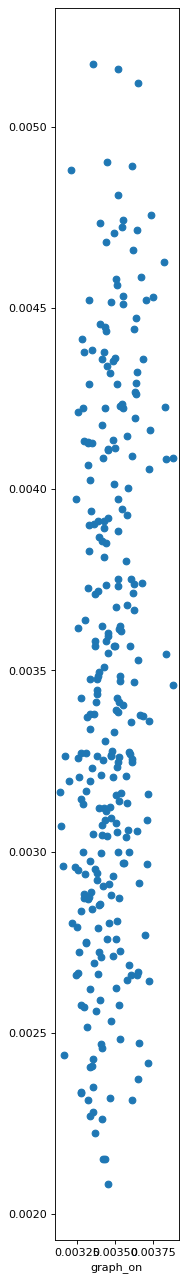

In [143]:
plt.scatter(delta_model['graph_off'], delta_model['graph_on'])
plt.xlabel('graph_off')
plt.xlabel('graph_on')

In [144]:
delta_model.sort_values('delta', ascending=False)

,delta,graph_on,graph_off
MIES,0.001816,0.005174,0.003358
AP1/2,0.001668,0.004881,0.003213
HD/5,0.001640,0.005161,0.003522
ZBTB49,0.001469,0.005121,0.003652
TBX/2,0.001457,0.004903,0.003446
...,...,...,...
TFAP2/1,-0.001278,0.002371,0.003649
ZNF136,-0.001282,0.002151,0.003433
MYB/5,-0.001297,0.002313,0.003610
NR/11,-0.001301,0.002415,0.003717


In [158]:
delta_model.sort_values('delta')

,delta,graph_on,graph_off
SPZ1,-0.001369,0.002083,0.003452
NR/11,-0.001301,0.002415,0.003717
MYB/5,-0.001297,0.002313,0.003610
ZNF136,-0.001282,0.002151,0.003433
TFAP2/1,-0.001278,0.002371,0.003649
...,...,...,...
TBX/2,0.001457,0.004903,0.003446
ZBTB49,0.001469,0.005121,0.003652
HD/5,0.001640,0.005161,0.003522
AP1/2,0.001668,0.004881,0.003213


In [155]:
# save values to compare with neurogenesis
delta_model.to_csv('../../../output/delta_log_act_exp_organoids.csv')

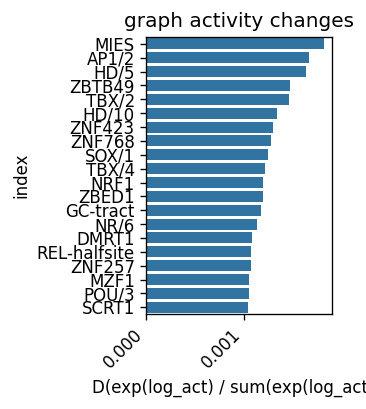

In [154]:
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = 2, 3
sns.barplot(data=delta_model.sort_values('delta', ascending=0).reset_index().head(20), x='delta', y='index')
plt.title('graph activity changes')
plt.xticks(rotation=45, ha='right')
plt.xlabel('D(exp(log_act) / sum(exp(log_act)))')
plt.savefig('../../../output/delta_log_act_exp_organoids.pdf')
plt.show()

<Axes: xlabel='value', ylabel='index'>

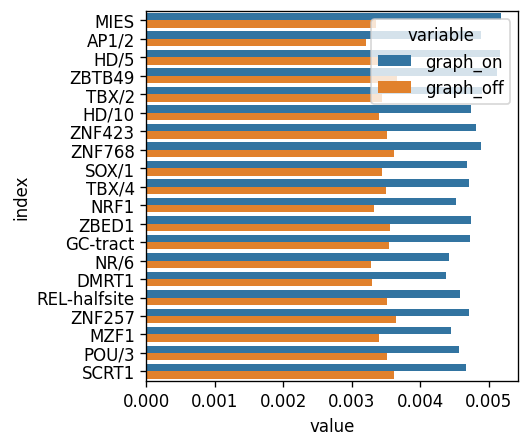

In [146]:
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = 4, 4
sns.barplot(data=bar_df[bar_df['index'].isin(top_delta)], y='index', x='value', hue='variable')

TFAP2/1:AP2B1 (0.07345569496410737, 0.4886544828823363) -0.0012776756193488836
GLI:GLI3 (0.06673836872487002, 0.4185288004480879) -0.0011470606550574303
MYB/5:MYBL2 (0.06613714779467816, 0.3669357496573806) -0.0012967518996447325
HD/8:UNCX (0.0618650755911005, -0.36700042547335276) -0.0011537550017237663
TFAP2/1:AP2A1 (0.05949032245827933, 0.3957516537221314) -0.0012776756193488836
TFAP2/1:AP2A2 (0.05874605742633961, 0.3908005271350421) -0.0012776756193488836
GLI:GLI2 (0.0583533483548184, 0.365944768439785) -0.0011470606550574303
SOX/3:SOX12 (0.055787255277487235, 0.45803356791672334) -0.0009434351231902838
GLI:GLI3 (0.05371978321367255, 0.3368868142617834) -0.0011470606550574303
SOX/3:SOX2 (0.04989091049644293, 0.40962244203688924) -0.0009434351231902838
ZNF232:ZNF232 (0.049576295224507946, 0.2671757981114644) -0.001266708131879568
SOX/4:SOX11 (0.04936573787102394, 0.48357673625190156) -0.0008825000841170549
NR/20:ARPC2 (0.04928995698990726, 0.6694552754610634) -0.0006756952498108149


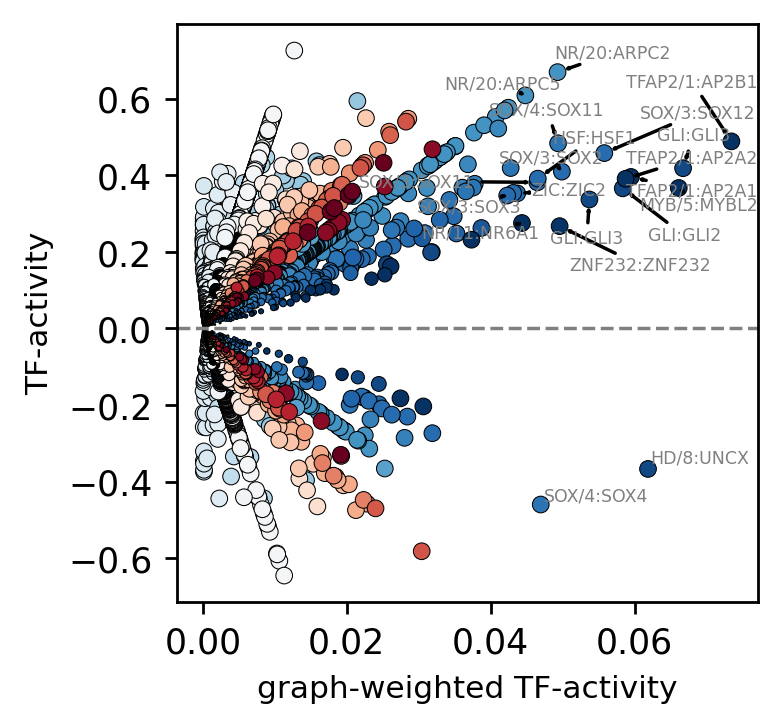

In [147]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 250
rcParams['pdf.fonttype'] = 42

from adjustText import adjust_text

res['act_change'] = res['module_name'].map(delta_model['delta'].to_dict())
res['k'] = res['module_name'] + ':' + res['gene_name']
res['graph_score'] = res['filter_id'].map({i : contrib_times_activities[0][i + 2] for i in range(len(contrib_times_activities[0]) - 2)})
res['z'] = np.sqrt((res['graph_score'] ** 2) * (-np.log(res['p_adj'] + 1e-10)) ** 2)


ax = plt.subplot()
cmap = sns.color_palette('RdBu_r', as_cmap=True)

res_sel = res.sort_values('z', ascending=False)
res_sel = res_sel.sort_values('z', ascending=False) # .drop_duplicates('module_name')
# res_sel = res_sel.drop_duplicates('module_name')

# res_sel['x'] = np.log((res_sel['graph_score'] + 1) * (res_sel['act_change'].abs() + 1))
res_sel['x'] = res_sel['graph_score'] * res_sel['act_change'].abs() * res_sel['spearman'].abs()

edgecolors = res_sel['gene_name'].map(ttrust['consensus'].to_dict())
edgecolors = np.where(~pd.isnull(edgecolors), edgecolors, 'gray')
res_sel['edgecolors'] = edgecolors
plt.scatter(res_sel['x'],            
            res_sel['spearman'],
            s=-np.log(res_sel['p_adj'] + 1e-10),
            cmap=cmap,
            lw=.3,
            edgecolors='black', # res_sel['edgecolors'],
            c=res_sel['act_change'])
plt.axhline(y=0, ls='--', c='gray', lw=1.0)
plt.xlabel('graph-weighted TF-activity', fontsize=9) # G_layer * abs(act) * abs(rho(GEX, act))'
plt.ylabel('TF-activity', fontsize=9) # rho(GEX, act)


res_sel = res_sel.sort_values('x', ascending=False) # .drop_duplicates('module_name')
texts = [] # [plt.text(x[i], y[i], 'Text%s' %i, ha='center', va='center') for i in range(len(x))]

for ri, r in res_sel.head(20).iterrows():
    print(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), r['act_change'])
    t = ax.annotate(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), fontsize=5, color=r['edgecolors'])
    texts.append(t)
adjust_text(texts, arrowprops=dict(arrowstyle='->'))

plt.savefig('../../../output/graph_contribution_neurogenesis.pdf')
plt.show()

In [148]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

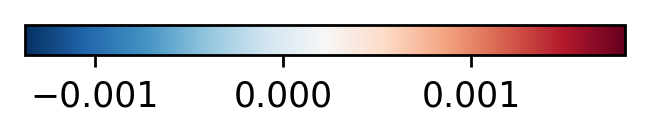

In [149]:
import pylab as pl
import numpy as np

a = np.array([[res_sel['act_change'].min(), res_sel['act_change'].max()]])
pl.figure(figsize=(3, .2))
img = pl.imshow(a, cmap="RdBu_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
pl.savefig("../../../output/graph_contribution_neurogenesis_cbar.pdf")

In [150]:
!readlink -f ../../../output/graph_contribution_neurogenesis.pdf

/home/ilibarra/workspace/theislab/mubind/output/graph_contribution_neurogenesis.pdf


In [151]:
print('here...')

here...


In [152]:

def running_mean(y_in, x_in, N_out=101, sigma=.05):
    '''
    Returns running mean as a Bell-curve weighted average at evenly spaced
    points. Does NOT wrap signal around, or pad with zeros.
    
    Arguments:
    y_in -- y values, the values to be smoothed and re-sampled
    x_in -- x values for array
    
    Keyword arguments:
    N_out -- NoOf elements in resampled array.
    sigma -- 'Width' of Bell-curve in units of param x .
    '''
    import numpy as np
    N_in = len(y_in)

    # Gaussian kernel
    x_out = np.linspace(np.min(x_in), np.max(x_in), N_out)
    x_in_mesh, x_out_mesh = np.meshgrid(x_in, x_out)
    gauss_kernel = np.exp(-np.square(x_in_mesh - x_out_mesh) / (2 * sigma**2))
    # Normalize kernel, such that the sum is one along axis 1
    normalization = np.tile(np.reshape(np.sum(gauss_kernel, axis=1), (N_out, 1)), (1, N_in))
    gauss_kernel_normalized = gauss_kernel / normalization
    # Perform running average as a linear operation
    y_out = gauss_kernel_normalized @ y_in

    return y_out, x_out

def plot_pseudotime(rna, gene_name, filter_name, sigma_gex=.05, sigma_filter=.1):
    rcParams['figure.figsize'] = 3, 2
    gene_key = gene_name
    x = rna.obs['velocity_pseudotime']
    y = rna[:,rna.var_names==gene_key].X.A.flatten()
    y = np.log(y)
    y[y == -np.inf] = np.nanmin(y[y != -np.inf])

    y_mean, x_mean = running_mean(y, x, sigma=sigma_gex)
    plt.scatter(x, y, edgecolors=None, color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='green')
    plt.ylabel('')
    plt.title(gene_key)
    plt.ylabel('gene expression [log]')
    plt.xlabel('pseudotime')


    x = ad.obs['velocity_pseudotime']

    plt.show()
    filter_id = int(res[res['module_name'].str.contains(filter_name)]['filter_id'].values[0])

    a = act_on
    a = a.exp() / a.exp().sum()

    y = a.T.numpy()[:,filter_id]
    # y = np.abs(y)
    # y = np.log(y)
    # y[y == -np.inf] = np.nanmin(y[y != -np.inf])
    y_mean, x_mean = running_mean(y, x, sigma=sigma_filter)
    # plt.scatter(x, y, edgecolors='black', color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='blue')
    plt.ylabel('')
    plt.title('filter activities %s' % filter_name)
    plt.ylabel('filter activity')
    plt.xlabel('pseudotime')


    a = act_off
    a = a.exp() / a.exp().sum()
    y = a.T.numpy()[:,filter_id]
    # y = np.abs(y)
    # y = np.log(y)
    # y[y == -np.inf] = np.nanmin(y[y != -np.inf])
    plt.show()

    y_mean, x_mean = running_mean(y, x, sigma=sigma_filter)
    # plt.scatter(x, y, edgecolors='black', color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='blue', linestyle='--')
    plt.ylabel('')
    plt.title('filter activities %s' % filter_name)
    plt.ylabel('filter activity')
    plt.xlabel('pseudotime')



In [153]:
plot_pseudotime(rna_sample, 'Gli3', 'GLI', sigma_gex=.05, sigma_filter=.1)

ValueError: zero-size array to reduction operation fmin which has no identity

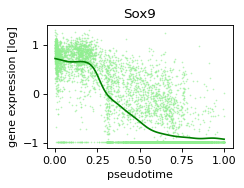

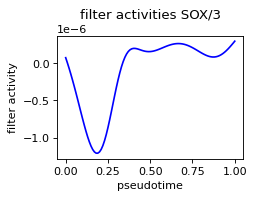

In [ ]:
plot_pseudotime(rna_sample, 'Sox9', 'SOX/3', sigma_gex=.05, sigma_filter=.1)

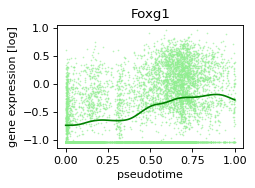

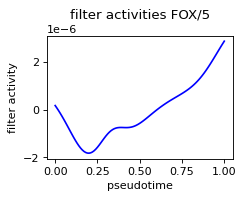

In [ ]:
plot_pseudotime(rna_sample, 'Foxg1', 'FOX/5', sigma_gex=.05, sigma_filter=.1)

In [ ]:
plot_pseudotime(rna_sample, 'Foxo6', 'FOX/5', sigma_gex=.05, sigma_filter=.1)

ValueError: zero-size array to reduction operation fmin which has no identity

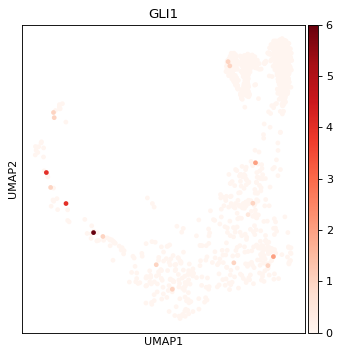

In [ ]:
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 80
sc.pl.umap(rna_sample, color=['GLI1'], cmap='Reds') #  'Nfil3', 'Arl8a', 'Rara', 'Tfap2c', 'Sox9', 'Qsox1', cell_type_key])


In [ ]:
ad

AnnData object with n_obs × n_vars = 1646 × 19883
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_cells_RNA', 'n_cells_ATAC', 'line', 'age', 'nCount_peaks', 'nFeature_peaks', 'S.Score', 'G2M.Score', 'Phase', 'nowakowski_prediction', 'RNA_snn_res.1', 'seurat_clusters', 'glyc_cluster', 'nCount_css', 'nFeature_css', 'RNA_snn_res.0.8', 'DF', 'MH', 'VF', 'X1', 'pred_class', 'ac_pole', 'antihem', 'cortical_hem', 'hindbrain_floor_plate', 'hindbrain_roof_plate', 'hypothalamic_floor_plate', 'isthmus', 'midbrain_basal_plate', 'midbrain_floor_plate', 'roof_plate', 'telencephalic_roof_plate', 'zona_limitans', 'pred_region', 'RNA_snn_res.2', 'patterning_region', 'n_counts', 'velocity_self_transition', 'neuron_type', 'terminal_states', 'terminal_states_probs', 'to_terminal_states_dp', 'clusters_gradients', 'to_ctx', 'to_nt', 'to_ge', 'velocity_pseudotime', 'to_nt_ranks', 'to_ge_ranks', 'to_ctx_ranks', 'is_root', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic

AttributeError: PathCollection.set() got an unexpected keyword argument 'edge_colors'

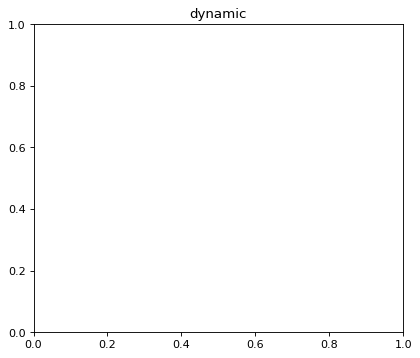

In [ ]:
sc.pl.embedding_density(ad[ad.obs_names[:3]], basis='umap', key='umap_density_dynamic_score_z1',
                        group='dynamic', color_map='viridis', edge_colors='black')
                        # save="dynamic_scores_neurogenesis.pdf") # basis='umap', groupby='dynamic_score_cluster')


AttributeError: PathCollection.set() got an unexpected keyword argument 'edge_colors'

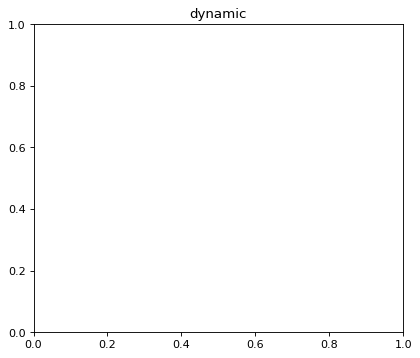

In [ ]:
# test custom edge colors
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic', color_map='viridis', edge_colors='black')
                        # save="dynamic_scores_neurogenesis.pdf") # basis='umap', groupby='dynamic_score_cluster')


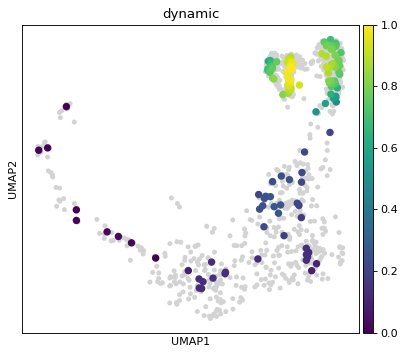

In [ ]:
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 80
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic', color_map='viridis',
                        save="dynamic_scores_neuroorganoids.pdf") # basis='umap', groupby='dynamic_score_cluster')
# plt.savefig(

In [ ]:
!readlink -f figures/dynamic_scores_neurogenesis.pdf

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/figures/dynamic_scores_neurogenesis.pdf


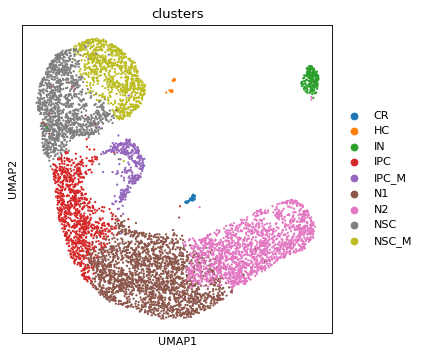

In [ ]:
rcParams['pdf.fonttype'] = 42
sc.pl.umap(rna_sample, color=cell_type_key, show=False)
plt.savefig("../../../output/annotation_neurogenesis.pdf")

saving figure to file ../../../output/velocity_stream_neuroorganoids.pdf


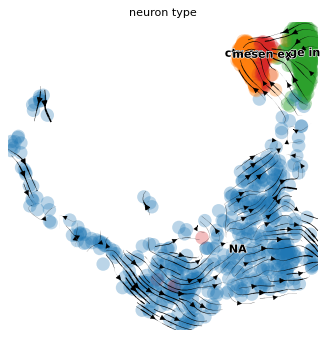

In [ ]:
rcParams['pdf.fonttype'] = 42
scv.pl.velocity_embedding_stream(rna_sample, color=cell_type_key, save="../../../output/velocity_stream_neuroorganoids")